In [4]:
import warnings
warnings.filterwarnings('ignore')
from cliotools.pcaskysub import build_raw_stack, build_skysubbed_stack, mask, highpassfilter,\
    findbadpix, badpixfix, plot
# Make a stack of the raw images in the dataset: 
path = "BDI0933/"
k = pd.read_csv(path+'ABLocations', 
                     delim_whitespace = True, # Spaces separate items in the list
                     comment = '#', # Ignore commented rows
                     names=['filename', 'xca','yca', 'xcb', 'ycb'] # specify column names
                    )

stack0, stack1, xca0, yca0, xcb0, ycb0, xca1, yca1, xcb1, ycb1 = build_raw_stack(k)

# High pass filter (unsharp mask) to remove spatial variation:
print('Highpassfilter Nod 0:')
hpf0 = highpassfilter(stack0) 
print('Highpassfilter Nod 1:')
hpf1 = highpassfilter(stack1)

# mask stars in each nod:
print('Masking stars')
masked0 = hpf0.copy()
for i in range(stack0.shape[0]):
    masked0[i,:,:] = mask(hpf0[i,:,:],[xca0[0],xcb0[0]],[yca0[0],ycb0[0]], radius = 80)
masked1 = hpf1.copy()
for i in range(stack1.shape[0]):
    masked1[i,:,:] = mask(hpf1[i,:,:],[xca1[0],xcb1[0]],[yca1[0],ycb1[0]], radius = 80)

print('Taking time-domain std dev')
# Take standard deviation in time domain:
std0 = np.nanstd(masked0, axis=0)
std1 = np.nanstd(masked1, axis=0)

Stacking reference images for BDI0933 ...
I found  67  images for Nod 0, and  69 images for Nod 1
Highpassfilter Nod 0:
100% (67 of 67): |####################|  Done...
Highpassfilter Nod 1:
100% (69 of 69): |####################|  Done...
Masking stars
Taking time-domain std dev


Find a chunk with no bad pixels:


<IPython.core.display.Javascript object>


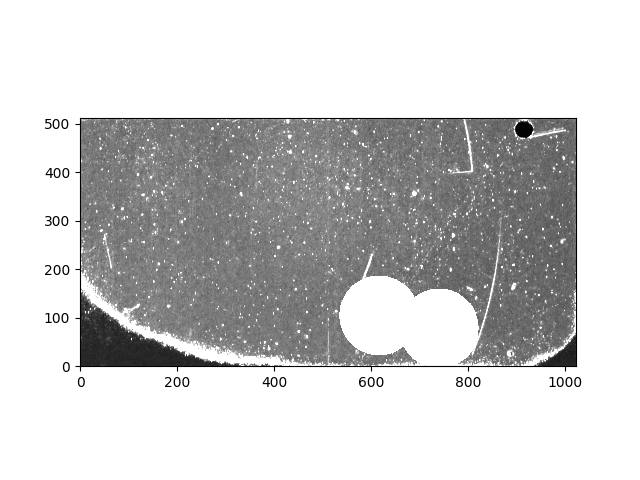

In [5]:
print('Find a chunk with no bad pixels:')
# Find a chunk of image with no visible bad pixels:
%matplotlib notebook
plot(std1)

Find a chunk with no bad pixels:


<IPython.core.display.Javascript object>


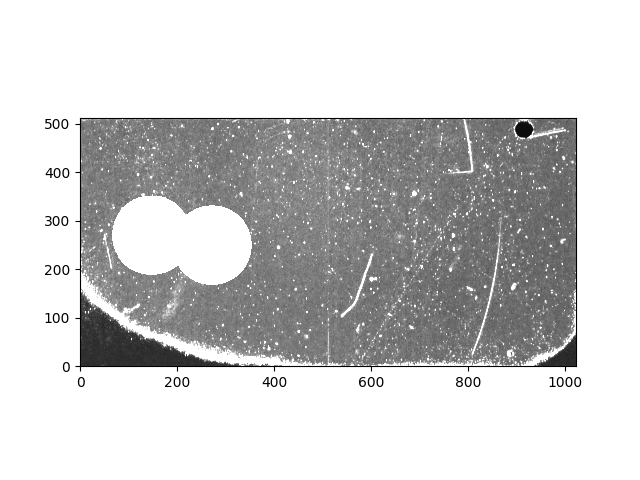

In [6]:
print('Find a chunk with no bad pixels:')
# Find a chunk of image with no visible bad pixels:
%matplotlib notebook
plot(std0)

Finding badpix
Opening skysubs
Fixing bad pix
Nod1:
100% (69 of 69): |####################|  Done...
Nod0:
100% (67 of 67): |####################|  Done...


<IPython.core.display.Javascript object>


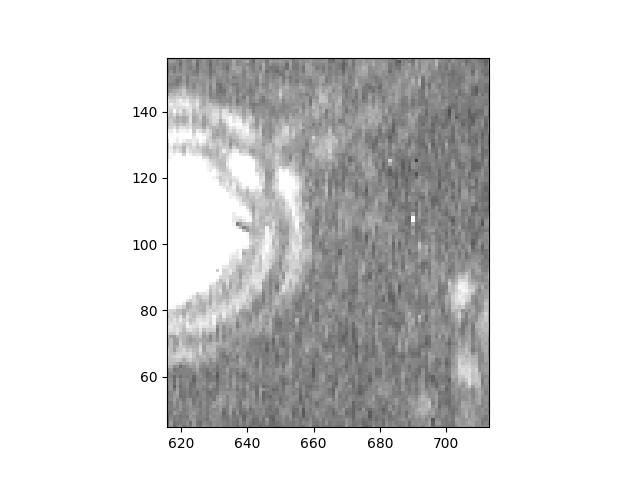

In [7]:
xmin, xmax = 185,215
ymin, ymax = 455,495
chunk0 = std0[ymin:ymax,xmin:xmax]
xmin, xmax = 315,352
ymin, ymax = 218,250
chunk1 = std1[ymin:ymax,xmin:xmax]

# Make a bad pix map for each nod:
print('Finding badpix')
n = 3
badpix0, badpixmap0 = findbadpix(std0, chunk0, n=n)
badpix1, badpixmap1 = findbadpix(std1, chunk1, n=n)

print('Opening skysubs')
# Make a new stack of the skysubbtracted images to fix:
images0,images1 = build_skysubbed_stack(k)
print('Fixing bad pix')
# Use the badpix index list to fix pixels in opposite nod:
print('Nod1:')
imfix1 = badpixfix(images1,badpix0)
print('Nod0:')
imfix0 = badpixfix(images0,badpix1)

<IPython.core.display.Javascript object>


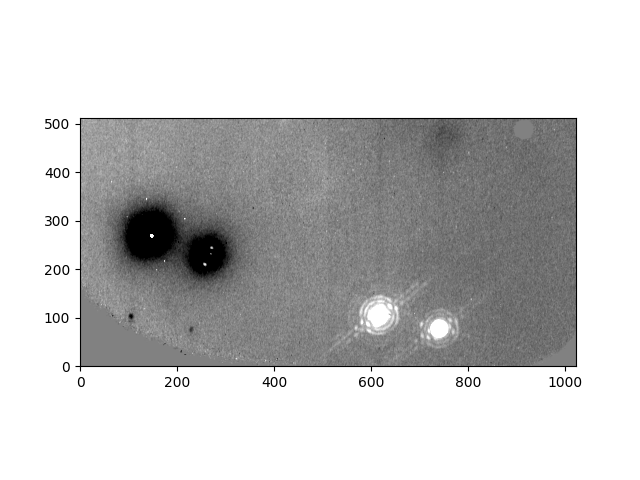

In [17]:
%matplotlib notebook
plot(imfix1[1])

100% (69 of 69): |####################|  Done...


<IPython.core.display.Javascript object>


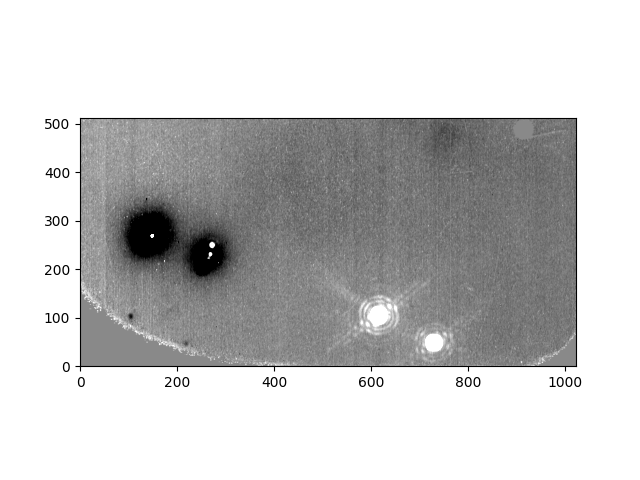

In [28]:
# Spot healing: pixels that need to be fixed near stars that weren't caught by automatic pipeline:
shx = [605,605,573,556,648,683,691,690,690,617,617,575,706,717,742,766,818,807,807,606,606,807,807,606,778,778,\
      779,779,570,570,617,617]
shy = [152,150,118,149,158,125,125,108,107,37,36,68,4,2,4,67,108,318,317,152,150,137,136,149,116,115,\
      116,115,28,31,35,38]

    
imfix1_2 = badpixfix(imfix1,[shy,shx])
%matplotlib notebook
plot(imfix1_2[46])

<IPython.core.display.Javascript object>


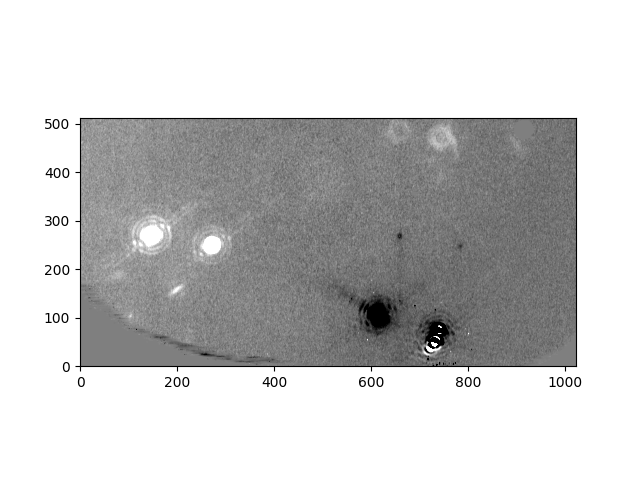

In [29]:
# Check your work:
%matplotlib notebook
plot(imfix0[0])

100% (67 of 67): |####################|  Done...


<IPython.core.display.Javascript object>


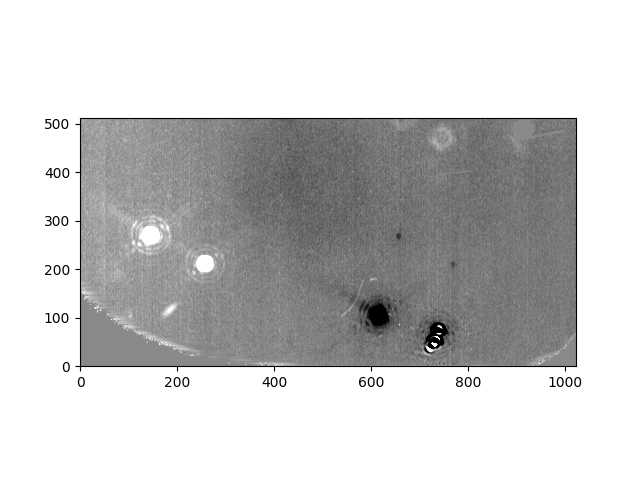

In [31]:
# Spot healing: pixels that need to be fixed near stars that weren't caught by automatic pipeline:
shx = [205,205,206,292]
shy = [320,319,320,299]

    
imfix0_2 = badpixfix(imfix0,[shy,shx])
%matplotlib notebook
plot(imfix0_2[46])

In [32]:
# Write out fixed images:
count0, count1 = 0,0
from astropy.io import fits
import time
for i in range(len(k)):
    imhdr = fits.getheader(k['filename'][i])
    imhdr['COMMENT'] = '    deep bad pixel corrected on '\
                           +time.strftime("%m/%d/%Y")+ ' By Logan A. Pearce'
    newname = (k['filename'][i]).split('_')[0]+'_'+(k['filename'][i]).split('_')[1]+'_ssbp.fit'
    if imhdr['BEAM'] == 0:
        print(newname, imhdr['BEAM'], count0)
        fits.writeto(newname, imfix0_2[count0], imhdr, overwrite=True)
        count0 += 1
    if imhdr['BEAM'] == 1:
        print(newname, imhdr['BEAM'], count1)
        fits.writeto(newname, imfix1_2[count1], imhdr, overwrite=True)
        count1 += 1
    

BDI0933/BDI0933_00001_ssbp.fit 0 0
BDI0933/BDI0933_00002_ssbp.fit 0 1
BDI0933/BDI0933_00003_ssbp.fit 0 2
BDI0933/BDI0933_00004_ssbp.fit 0 3
BDI0933/BDI0933_00005_ssbp.fit 0 4
BDI0933/BDI0933_00006_ssbp.fit 0 5
BDI0933/BDI0933_00007_ssbp.fit 0 6
BDI0933/BDI0933_00008_ssbp.fit 0 7
BDI0933/BDI0933_00009_ssbp.fit 0 8
BDI0933/BDI0933_00010_ssbp.fit 0 9
BDI0933/BDI0933_00011_ssbp.fit 0 10
BDI0933/BDI0933_00012_ssbp.fit 0 11
BDI0933/BDI0933_00013_ssbp.fit 0 12
BDI0933/BDI0933_00014_ssbp.fit 0 13
BDI0933/BDI0933_00015_ssbp.fit 0 14
BDI0933/BDI0933_00016_ssbp.fit 1 0
BDI0933/BDI0933_00017_ssbp.fit 1 1
BDI0933/BDI0933_00018_ssbp.fit 1 2
BDI0933/BDI0933_00019_ssbp.fit 1 3
BDI0933/BDI0933_00020_ssbp.fit 1 4
BDI0933/BDI0933_00021_ssbp.fit 1 5
BDI0933/BDI0933_00022_ssbp.fit 1 6
BDI0933/BDI0933_00023_ssbp.fit 1 7
BDI0933/BDI0933_00024_ssbp.fit 1 8
BDI0933/BDI0933_00025_ssbp.fit 1 9
BDI0933/BDI0933_00026_ssbp.fit 1 10
BDI0933/BDI0933_00027_ssbp.fit 1 11
BDI0933/BDI0933_00028_ssbp.fit 1 12
BDI0933/BDI0

In [40]:
# Finally, write out the list of sky subbed, bad pixel fixed, cleaned images:
g = k.copy()
for i in range(len(k)):
    newname = (k['filename'][i]).split('_')[0]+'_'+(k['filename'][i]).split('_')[1]+'_ssbp.fit'
    g['filename'][i] = newname
g.to_csv(path+'CleanList', index=False)

In [41]:
m = pd.read_csv(path+'CleanList')
m

,filename,xca,yca,xcb,ycb
0,BDI0933/BDI0933_00001_ssbp.fit,147.357771,268.362092,272.244137,248.195362
1,BDI0933/BDI0933_00002_ssbp.fit,147.272577,268.437468,272.084283,247.889465
2,BDI0933/BDI0933_00003_ssbp.fit,147.285582,268.551278,272.052040,247.449307
3,BDI0933/BDI0933_00004_ssbp.fit,147.297234,268.799922,271.993570,247.340859
4,BDI0933/BDI0933_00005_ssbp.fit,147.423288,269.023987,272.066308,247.188374
5,BDI0933/BDI0933_00006_ssbp.fit,147.325197,269.001565,271.845911,246.787669
6,BDI0933/BDI0933_00007_ssbp.fit,147.657243,268.393916,272.066359,245.724816
7,BDI0933/BDI0933_00008_ssbp.fit,147.750098,268.733263,272.133145,245.636799
8,BDI0933/BDI0933_00009_ssbp.fit,147.840318,268.661121,272.099728,245.131545
9,BDI0933/BDI0933_00010_ssbp.fit,147.583072,268.636453,271.761722,244.705162
